In [1]:
import torch
import transformers
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

from transformers import Trainer, TrainingArguments
from transformers import BertTokenizer
from transformers import BertPreTrainedModel, BertModel, DistilBertPreTrainedModel, DistilBertModel, DistilBertConfig
from transformers import RobertaTokenizer

import pandas as pd
import numpy as np
import os
import csv

from sklearn.metrics import classification_report

# just checking somethingdf
from datasets import Dataset

# my custom function
import utils
import importlib
from sklearn.model_selection import train_test_split

# import the libraries from bert
from bert import BERT_PCL, PCLDataset, Trainer_PCL, DistillBert_PCL, RobertaPCL
from bert import predict_pcl
import bert

if not torch.cuda.is_available():
  print('WARNING: You may want to change the runtime to GPU for faster training!')
  DEVICE = 'cpu'
else:
  DEVICE = 'cuda:0'

import os
import pickle
from itertools import product
content = os.path.abspath('/vol/bitbucket/ahf119/')

In [2]:
importlib.reload(bert)

<module 'bert' from '/homes/ahf119/Desktop/nlp_cw/bert.py'>

In [17]:
print(DEVICE)

cuda:0


In [18]:
def get_pred(model, data_loader):
    total_count = 0
    correct_count = 0
    preds = []
    tot_labels = []

    with torch.no_grad():
        for data in tqdm(data_loader):
            labels = {}
            labels['label'] = data['labels']
            text = data['input_ids']
            attention = data['attention_mask']
            pred = predict_pcl(text, attention, model)

            preds.append(pred['prediction'].tolist())

    return preds

In [19]:
### LOAD ROBERTA MODEL AND GET VALIDATION DATA ###

In [20]:
_, val_dataset, test_dataset = bert.all_augmentations(model_type = 'roberta-base')

inserted False
subbed False
back_translated True
deleted False
swapped False


In [21]:
model_path = "best_model_roberta"
model = RobertaPCL.from_pretrained(model_path)

In [22]:
preds_roberta_test = get_pred(model, DataLoader(test_dataset))

  0%|          | 0/2094 [00:00<?, ?it/s]

In [23]:
preds_roberta_test = np.array(preds_roberta_test).reshape(-1)

In [24]:
np.save('predictions/preds_roberta_test.npy', preds_roberta_test)

In [25]:
### BERT CASED

In [26]:
_, val_dataset, test_dataset = bert.all_augmentations(model_type = 'bert-base-cased')

inserted False
subbed False
back_translated True
deleted False
swapped False


In [27]:
model_path = "bert_cased_best_model/best_model"
model = BERT_PCL.from_pretrained(model_path)

In [28]:
preds_bert_base_cased_test = get_pred(model, DataLoader(test_dataset))

  0%|          | 0/2094 [00:00<?, ?it/s]

In [29]:
preds_bert_base_cased_test = np.array(preds_bert_base_cased_test).reshape(-1)

In [30]:
np.save('predictions/preds_bert_cased_test.npy', preds_bert_base_cased_test)

In [ ]:
### BERT UN-CASED ###

In [31]:
_, val_dataset, test_dataset = bert.all_augmentations(model_type = 'bert-base-uncased')

inserted False
subbed False
back_translated True
deleted False
swapped False


In [32]:
model_path = "best_model_uncased"
model = BERT_PCL.from_pretrained(model_path)

In [33]:
preds_bert_base_uncased_test = get_pred(model, DataLoader(test_dataset))

  0%|          | 0/2094 [00:00<?, ?it/s]

In [34]:
preds_bert_base_uncased_test = np.array(preds_bert_base_uncased_test).reshape(-1)

In [35]:
np.save('predictions/preds_bert_uncased_test.npy', preds_bert_base_uncased_test)

In [52]:
### True labels

In [38]:
# Validation

true_test = []

for i in range(len(test_dataset)):
    true_test.append(test_dataset[i]['labels'].item())

true_test = np.array(true_test)

np.save('predictions/true_test.npy', true_test)

In [ ]:
# Test

true_val = []

for i in range(len(val_dataset)):
    true_val.append(val_dataset[i]['labels'].item())

true_val = np.array(true_val)

np.save('predictions/true_val.npy', true_val)

### Get metrics VALIDATION

In [3]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

true_val = np.load('predictions/true_val.npy')

In [4]:
preds_roberta_val = np.load('predictions/preds_roberta_val.npy')

print("ROBERTA BASED")
print("F1: {}".format(f1_score(true_val, preds_roberta_val, pos_label=1)))
print("Recall: {}".format(recall_score(true_val, preds_roberta_val, pos_label=1)))
print("Precision: {}".format(precision_score(true_val, preds_roberta_val, pos_label=1)))

ROBERTA BASED
F1: 0.6033519553072626
Recall: 0.6303501945525292
Precision: 0.5785714285714286


In [5]:
preds_bert_base_cased = np.load('predictions/preds_bert_cased_val.npy')

print("BERT BASE CASED")
print("F1: {}".format(f1_score(true_val, preds_bert_base_cased, pos_label=1)))
print("Recall: {}".format(recall_score(true_val, preds_bert_base_cased, pos_label=1)))
print("Precision: {}".format(precision_score(true_val, preds_bert_base_cased, pos_label=1)))

BERT BASE CASED
F1: 0.5595667870036101
Recall: 0.603112840466926
Precision: 0.5218855218855218


In [6]:
preds_bert_base_uncased = np.load('predictions/preds_bert_uncased_val.npy')

print("BERT BASE UNCASED")
print("F1: {}".format(f1_score(true_val, preds_bert_base_uncased, pos_label=1)))
print("Recall: {}".format(recall_score(true_val, preds_bert_base_uncased, pos_label=1)))
print("Precision: {}".format(precision_score(true_val, preds_bert_base_uncased, pos_label=1)))

BERT BASE UNCASED
F1: 0.5619834710743802
Recall: 0.5291828793774319
Precision: 0.5991189427312775


In [7]:
or_ensemble = np.int8(np.logical_or(preds_bert_base_cased, preds_roberta_val))

print("OR ENSEMBLE OF ROBERT AND BERT CASED")
print("F1: {}".format(f1_score(true_val, or_ensemble, pos_label=1)))
print("Recall: {}".format(recall_score(true_val, or_ensemble, pos_label=1)))
print("Precision: {}".format(precision_score(true_val, or_ensemble, pos_label=1)))

OR ENSEMBLE OF ROBERT AND BERT CASED
F1: 0.588957055214724
Recall: 0.7470817120622568
Precision: 0.4860759493670886


In [8]:
val_or_ensemble = np.int8((preds_bert_base_uncased + preds_roberta_val + preds_bert_base_cased) > 0)

print("OR ENSEMBLE OF ROBERT AND BERT UNCASED")
print("F1: {}".format(f1_score(true_val, val_or_ensemble, pos_label=1)))
print("Recall: {}".format(recall_score(true_val, val_or_ensemble, pos_label=1)))
print("Precision: {}".format(precision_score(true_val, val_or_ensemble, pos_label=1)))

OR ENSEMBLE OF ROBERT AND BERT UNCASED
F1: 0.584070796460177
Recall: 0.7704280155642024
Precision: 0.47030878859857483


In [9]:
val_majority_vote_ensemble = np.int8((preds_bert_base_uncased + preds_roberta_val + preds_bert_base_cased) > 1)

print("MAJORITY VOTE ENSEMBLE OF ALL THREE")
print("F1: {}".format(f1_score(true_val, val_majority_vote_ensemble, pos_label=1)))
print("Recall: {}".format(recall_score(true_val, val_majority_vote_ensemble, pos_label=1)))
print("Precision: {}".format(precision_score(true_val, val_majority_vote_ensemble, pos_label=1)))

MAJORITY VOTE ENSEMBLE OF ALL THREE
F1: 0.5952380952380952
Recall: 0.5836575875486382
Precision: 0.6072874493927125


In [10]:
val_logistic_regression = np.load('predictions/val_logistic_regression.npy')
majority_vote_ensemble = np.int8((val_logistic_regression + preds_bert_base_uncased + preds_roberta_val + preds_bert_base_cased) > 2)

print("MAJORITY VOTE ENSEMBLE OF ALL THREE")
print("F1: {}".format(f1_score(true_val, majority_vote_ensemble, pos_label=1)))
print("Recall: {}".format(recall_score(true_val, majority_vote_ensemble, pos_label=1)))
print("Precision: {}".format(precision_score(true_val, majority_vote_ensemble, pos_label=1)))

MAJORITY VOTE ENSEMBLE OF ALL THREE
F1: 0.5570175438596491
Recall: 0.49416342412451364
Precision: 0.6381909547738693


### Get metrics TEST

In [11]:
true_test = np.load('predictions/true_test.npy')

In [12]:
preds_roberta_test = np.load('predictions/preds_roberta_test.npy')

print("ROBERTA BASED")
print("F1: {}".format(f1_score(true_test, preds_roberta_test, pos_label=1)))
print("Recall: {}".format(recall_score(true_test, preds_roberta_test, pos_label=1)))
print("Precision: {}".format(precision_score(true_test, preds_roberta_test, pos_label=1)))

ROBERTA BASED
F1: 0.5213270142180095
Recall: 0.5527638190954773
Precision: 0.49327354260089684


In [13]:
preds_bert_cased_test = np.load('predictions/preds_bert_cased_test.npy')

print("BERT BASE CASED")
print("F1: {}".format(f1_score(true_test, preds_bert_cased_test, pos_label=1)))
print("Recall: {}".format(recall_score(true_test, preds_bert_cased_test, pos_label=1)))
print("Precision: {}".format(precision_score(true_test, preds_bert_cased_test, pos_label=1)))

BERT BASE CASED
F1: 0.5092592592592593
Recall: 0.5527638190954773
Precision: 0.4721030042918455


In [14]:
preds_bert_uncased_test = np.load('predictions/preds_bert_uncased_test.npy')

print("BERT BASE CASED")
print("F1: {}".format(f1_score(true_test, preds_bert_uncased_test, pos_label=1)))
print("Recall: {}".format(recall_score(true_test, preds_bert_uncased_test, pos_label=1)))
print("Precision: {}".format(precision_score(true_test, preds_bert_uncased_test, pos_label=1)))

BERT BASE CASED
F1: 0.48346055979643765
Recall: 0.47738693467336685
Precision: 0.4896907216494845


In [21]:
test_majority_vote_ensemble = np.int8((preds_bert_uncased_test + preds_roberta_test + preds_bert_cased_test) > 1)

print("MAJORITY VOTE ENSEMBLE OF ALL THREE")
print("F1: {}".format(f1_score(true_test, test_majority_vote_ensemble, pos_label=1)))
print("Recall: {}".format(recall_score(true_test, test_majority_vote_ensemble, pos_label=1)))
print("Precision: {}".format(precision_score(true_test, test_majority_vote_ensemble, pos_label=1)))

MAJORITY VOTE ENSEMBLE OF ALL THREE
F1: 0.5279187817258884
Recall: 0.5226130653266332
Precision: 0.5333333333333333


### SAVE MAJORITY ENSEMBLE AS .txt

In [24]:
np.savetxt('dev.txt', np.int32(test_majority_vote_ensemble), fmt='%d')

In [16]:
test_or_ensemble = np.int8((preds_bert_uncased_test + preds_roberta_test + preds_bert_cased_test) > 0)


print("MAJORITY VOTE ENSEMBLE OF ALL THREE")
print("F1: {}".format(f1_score(true_test, test_or_ensemble, pos_label=1)))
print("Recall: {}".format(recall_score(true_test, test_or_ensemble, pos_label=1)))
print("Precision: {}".format(precision_score(true_test, test_or_ensemble, pos_label=1)))

MAJORITY VOTE ENSEMBLE OF ALL THREE
F1: 0.5171790235081374
Recall: 0.7185929648241206
Precision: 0.403954802259887


### Plotting

In [17]:
import matplotlib.pyplot as plt

In [18]:
model_labels = [
    'RoBERTa',
    'BERT\n- UNCASED',
    'BERT\n- CASED',
    'ENSEMBLE\n- MAJORITY',
    'ENSEMBLE\n- OR GATE'
    ]

f1_results_val = [
    f1_score(true_val, preds_roberta_val, pos_label=1),
    f1_score(true_val, preds_bert_base_uncased, pos_label=1),
    f1_score(true_val, preds_bert_base_cased, pos_label=1),
    f1_score(true_val, val_or_ensemble, pos_label=1),
    f1_score(true_val, val_majority_vote_ensemble, pos_label=1)
    ]

f1_results_test = [
    f1_score(true_test, preds_roberta_test, pos_label=1),
    f1_score(true_test, preds_bert_cased_test, pos_label=1),
    f1_score(true_test, preds_bert_cased_test, pos_label=1),
    f1_score(true_test, test_majority_vote_ensemble, pos_label=1),
    f1_score(true_test, test_or_ensemble, pos_label=1),
    ]

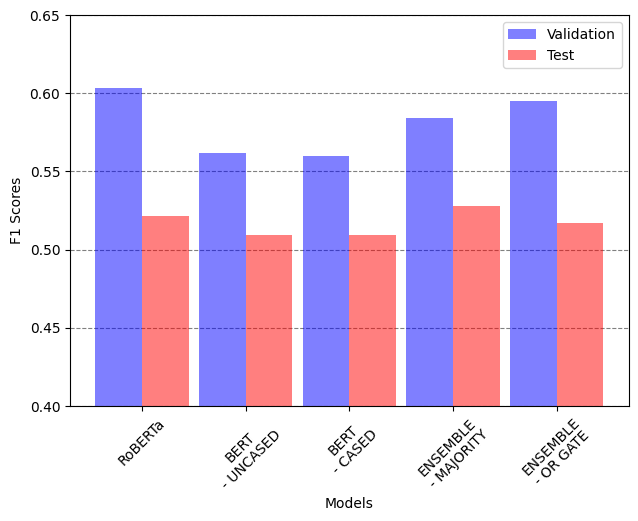

In [103]:
alpha = 0.5

x = np.arange(len(model_labels))  # the label locations
width = 0.45  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, f1_results_val, width, label='Validation', color='blue', alpha = alpha)
rects2 = ax.bar(x + width/2, f1_results_test, width, label='Test', color='red', alpha = alpha)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Models')
ax.set_ylabel('F1 Scores')
ax.set_xticks(x)
ax.set_xticklabels(model_labels)
ax.legend()

# Set grid
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')

fig.tight_layout()

plt.ylim(0.4, 0.65)



plt.xticks(rotation=45)

plt.savefig('figs/model_comparisons.png', bbox_inches='tight' )

plt.show()